<a href="https://colab.research.google.com/github/bokutachi256/gisday2023/blob/main/GISDay2023_%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# マルチエージェントシミュレーションを使った人の動きのシミュレーション

* 東京都立大学 都市環境学部 地理環境学科 中山大地
* 2023年11月18日 東京都立大学 南大沢キャンパス
* このテキストのURL [https://github.com/bokutachi256/gisday2023](https://github.com/bokutachi256/gisday2023)
* Google ColaboratoryのURL [https://colab.research.google.com/](https://colab.research.google.com/)

# 使い方

## データの準備

1. Googleドライブに`gisday2023`フォルダを作成する．
2. `data`フォルダに加重コスト距離のラスタデータファイル（例：`CostDis.tif`），スタート地点のGeoJSONファイル（`start_points.geojson`），ゴール地点のGeoJSONファイル（`goal_points.geojson`），道路のラスタデータファイル（`road.tif`）を格納する．
   1. すべてのデータは同じ座標系であること．
   2. ラスタデータはすべて同じサイズであること．
   3. 道路（壁）ファイルは通れる部分が1以上，通れない部分が0のラスタファイル
   4. 加重コスト距離ファイルは複数でも可
   5. スタート地点のGeoJSONに必須の属性
      * `cost_ID`: どの加重コスト距離に従うかを示す属性
   6. ゴール地点のGeoJSONに必須の属性は特になし．

## 計算結果をQGISで図化する

* gpkgの読み込み
  1. GoogleDriveからgpkgファイルをダウンロードする．
  1. gpkgファイルをQGISで読み込む．
* 時系列プロパティの設定
  1. gpkgレイヤーのプロパティを表示し，左側のボタンから「時系列」を選ぶ．
  1. 「動的時系列コントロール」にチェックを入れる．
  1. 「設定」を「Date/Time型の単一フィールド」，「上限」を「始点を含み終点を除く（デフォルト）」，「フィールド」を「Time」，「継続時間」を5秒にする．「地物を累積表示」にはチェックを入れない．
* 時系列表示の設定
  1. 「ビュー」メニューの「パネル」から「時系列コントローラーパネル」を表示する．
  1. 「時系列コントローラーパネル」の真ん中の時計ボタン（固定範囲の時系列ナビ）を押す．
  1. 時系列の範囲が表示されるので，範囲の右端にあるくるくる矢印ボタン（「全範囲に設定」）を押し，範囲を最初から最後までに設定する．
  1. 「時系列コントローラーパネル」の右端の再生ボタンを押し，スライダーを動かしてアニメ表示する．

# データファイルの指定

In [ ]:
# 必要なデータファイルの指定

# コスト距離ファイルの指定
# コスト距離はファイル名のリストで複数指定できる
cost_files = ['CostDis.tif']

# 道路ラスタファイルの指定
# 通れる部分が1以上，通れない部分が0のラスタファイル
road_file = 'road.tif'

# スタート地点のgeojsonファイルの指定
start_geojson = 'start_points500.geojson'

# ゴール地点のgeojsonファイルの指定
goal_geojson = 'goal_points.geojson'

# ライブラリのインポート

Google Colaboratoryを使う場合とローカルPCで実行する場合を自動判別して
必要なライブラリをインストールする．

In [ ]:
import sys

# Google Colaboratoryを使用している場合は以下の必須ライブラリをインストールする
# mesa: マルチエージェントシミュレーションライブラリ
# geopandas: 地理情報データを扱うライブラリ
if 'google.colab' in sys.modules:
  %pip install mesa
  %pip install geopandas
  %matplotlib notebook
  # google.coalb: GoogleDrive内のファイルにアクセスするために必要
  from google.colab import drive

# 必要なライブラリの読み込み
# numpy: 配列を扱うライブラリ
# tqdm: プログレスバーのライブラリ
# random: 乱数を扱うライブラリ
import numpy as np
from tqdm import tqdm
import random

# matplotlob: グラフ表示を行うライブラリ
# matplotlib..cm: matplotlibでカラーマップを扱うライブラリ
# matplotlib animation: アニメーション作成ライブラリ
# Ipython.display: アニメーション表示用ライブラリ
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation, rc
from matplotlib.animation import ArtistAnimation
#from IPython.display import HTML

# datetime: 時刻日付型のライブラリ
from datetime import date, time, datetime, timedelta

# mesa: マルチエージェントシミュレーションを行うライブラリ
from mesa import Agent, Model

# MultiGrid: 同一グリッドに複数エージェントを配置できるスペース
# SingleGrid: 同一グリッドに単一エージェントのみを配置できるスペース
from mesa.space import MultiGrid, SingleGrid

# RandomActivation: エージェントを動かす順番をランダムに決定
# SimultaneousActivation: エージェントを同時に動かす
from mesa.time import RandomActivation, SimultaneousActivation

# DataCollector: データコレクター
from mesa.datacollection import DataCollector

# osgeo: GeoTiffを読み込むために必要
from osgeo import gdal, gdalconst, gdal_array, osr

# geopandas: GeojJSONの読み込みとエージェントの座標計算に必要
import geopandas as gpd


# データ用フォルダのマウント

Google Colaboratryで実行する場合とローカルPCで実行する場合を自動判別し，
それぞれのデータフォルダをマウントする．

In [ ]:
# Google Colaboratoryを使う場合はGoogle Driveをマウントする
if 'google.colab' in sys.modules:
  drive.mount('/content/drive')
  # GoogleDrive内の"マイドライブ/gisday2023/"フォルダにアクセスできるような設定を行う．
  # フォルダ名の最後に`/`を必ず追加すること．
  base_dir = "/content/drive/My Drive/gisday2023/"
else:
  # ローカルPCを使う場合は./data/フォルダをマウントする
  # フォルダ名の最後に`/`を必ず追加すること．
  base_dir = "./data/"

# 加重コスト距離・壁・スタート地点・ゴール地点の読み込み

In [ ]:
# 加重コスト距離の読み込み
# cost_filesで指定されたGeoTIFFファイルを順次読み込み，リストcostに格納する．
cost = list()
for i in range(len(cost_files)):
  cost_file = gdal.Open(base_dir + cost_files[i])
  cost.append(np.where(cost_file.ReadAsArray() > 0, cost_file.ReadAsArray(), 0))

# GeoTIFF画像の左上座標（ULX, ULY），ピクセルサイズ(Ysize, Xsize）を取得する．
ULX, Xsize, dum1, ULY, dum2, Ysize = cost_file.GetGeoTransform()

# 道路（壁）の読み込み
wall_file = gdal.Open(base_dir + road_file)
wall = np.where(wall_file.ReadAsArray() >= 1, 0, 1)

# スタート地点のgeojsonの読み込み
# ラスタデータの周辺部にあるスタート地点は範囲外になる可能性があるために削除する
# テスト用のデータはsampleメソッドをつかって200地点くらいをサンプリングした方がよいかも
start_location = gpd.read_file(base_dir + start_geojson).explode(index_parts = True)\
  .cx[ULX+Xsize: ULX + ((cost_file.RasterXSize - 1) * Xsize), ULY + ((cost_file.RasterYSize + 1) * Ysize): ULY + Ysize]

# ゴール地点のgeojsonの読み込み
goal_location = gpd.read_file(base_dir + goal_geojson).explode(index_parts = True)


# スペースとエージェントを定義する

In [ ]:
class EvacModel(Model):
  # スペースのコンストラクタ
  # width: スペースの幅（グリッド数）
  # height: スペースの高さ（グリッド数）
  # start_loc: 避難者エージェントのスタート地点（GeoDataframe型式）
  # goal_loc: ゴール地点のGeoDataDFrame
  # wall: 道路データ
  # cost_data: コストラスタを格納したリスト
  def __init__(self, width, height, start_loc, goal_loc, wall, cost_data):

    # スペースをMultiGridにする
    # MultiGridは同一座標に複数エージェントを配置できるスペース
    self.grid = MultiGrid(width, height, torus = False)

    # 壁の座標を保持するプロパティの宣言
    self.wall = wall
    self.wall_x = list()
    self.wall_y = list()

    # スタート地点の座標を保持するプロパティの宣言
    self.start_x = list()
    self.start_y = list()

    # ゴール地点の座標を保持するプロパティの宣言
    self.goal_x = list()
    self.goal_y = list()

    # 加重コストに関するプロパティの宣言
    self.cost = cost_data
    self.cost_x = list()
    self.cost_y = list()

    # 避難完了者数を0で初期化
    self.evac_comp = 0

    # EvacAgentの実行順序をランダムにする
    # EvacAgentの実行順序を同時にしたい場合にはSimultaneousActivationをオンにする
    self.schedule = RandomActivation(self)
    # self.schedule = SimultaneousActivation(self)

    # スタート地点の人口を取得する
    #start_pop = start_location['pop'].to_list()

    # スタート地点のエージェントが参照する加重コスト距離の番号を取得する
    eva_no = start_location['cost_ID'].to_list()

    # 高齢者かどうかを判別する情報を取得する
    # senior = start_location['senior'].to_list()
    # start_move = [1 if a == 0 else 50 for a in senior]

    # スタート地点の座標を取得する
    start_x = ((start_location.geometry.x - ULX) // Xsize).to_list()
    start_y = ((start_location.geometry.y - ULY) // Ysize).to_list()

    # 避難者エージェントの数を取得する
    self.num_agents = len(start_x)

    # 避難者エージェントの配置
    for i in range(self.num_agents):
      a = EvacAgent(i, self)
      # 避難者エージェントの人口プロパティをセット
      # a.pop = start_pop[i]
      a.pop = 1
      # 避難者エージェントが目指す避難所番号をセット
      a.evac_no = eva_no[i]
      # 高齢者エージェントと通常エージェントでスタート時刻を変える
      # a.start_move = start_move[i]
      # a.start_move = start_move[i] + random.randrange(1, 100)
      a.start_move = random.randrange(1, 20)

      # 避難者エージェントをスケジューラーに登録
      self.schedule.add(a)
      # 避難者エージェントを配置する
      # 座標はintにキャストする
      self.grid.place_agent(a, (int(start_x[i]), int(start_y[i])))

      # データコレクターの設定
      self.datacollector = DataCollector(
        model_reporters = {"Goal": compute_goal, "evacuator": goal_pop, "pop_sum": pop_sum},
        agent_reporters = {"Pos": "pos", "Goal": "mygoal", "Strategy": "strategy",\
                            "Behavior": "behavior", "Pop": "pop", "Evac_no": "evac_no", "start_move": "start_move"})

    # 避難者エージェント配置直後（初期状態）の状況をデータコレクターで取得
    self.datacollector.collect(self)

    # 壁エージェントを配置する
    # 壁の配列から座標を取得する
    wall_y = np.where(self.wall > 0)[0]
    wall_x = np.where(self.wall > 0)[1]
    # 取得した壁の座標に壁エージェントを配置する
    for i in range(len(wall_x)):
      a = WallAgent(i, self)
      self.grid.place_agent(a, (int(wall_x[i]), int(wall_y[i])))
      # 描画用に壁の座標を保持する
      self.wall_x.append(int(wall_x[i]))
      self.wall_y.append(int(wall_y[i]))

    # ゴール地点の座標を取得する
    goal_x = ((goal_location.geometry.x - ULX) // Xsize).to_list()
    goal_y = ((goal_location.geometry.y - ULY) // Ysize).to_list()

    # ゴールエージェントの配置
    for i in range(len(goal_x)):
      a = GoalAgent(i, self)
      self.grid.place_agent(a, (int(goal_x[i]), int(goal_y[i])))
      # 描画用にゴールの座標を保持する
      self.goal_x.append(int(goal_x[i]))
      self.goal_y.append(int(goal_y[i]))

  def step(self):
    model.evac_comp = 0
    self.schedule.step()
    self.datacollector.collect(self)

# そのステップでゴールした人数を求める関数
def goal_pop(model):
  return(model.evac_comp)

# ゴールしたエージェントの累計を求める関数
def compute_goal(model):
  agent_goal = sum([agent.mygoal for agent in model.schedule.agents])
  return (agent_goal)

# ゴールした人数の実際の累計を求める関数
def pop_sum(model):
  pop_sum = sum([agent.pop for agent in model.schedule.agents if agent.mygoal == 1])
  return (pop_sum)

# 二つのエージェントの距離を求める関数
def calc_dist(loc1, loc2):
  return np.sqrt(np.sum(np.square(np.array(loc1)-np.array(loc2))))

# 避難者エージェントの定義
class EvacAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.mygoal = 0
    self.wealth = 0
    self.category = 'evacagent'

#    self.strategy = random.randrange(1, 5)
#    self.strategy = random.randrange(5, 10)

    # エージェントの避難ルール
    # behaviorは避難行動のパターン．1の場合は最寄りゴールに向かう．0の場合は道路コストに従って移動する
    # start_moveは避難を開始するステップ数
    # strategyはエージェントがゴールを探す半径

    # 1. 全員が最寄りゴールに向かう．同時に避難開始
    # self.strategy = 100
    # self.start_move = 1
    # self.behavior = 1

    # 2. 全員が道路コストに従ってゴールに向かう．同時に避難開始
    self.strategy = 100
    # self.start_move = 1
    # self.start_move += random.randrange(1, 10)
    self.behavior = 0

    # 3. 避難開始のステップ数をランダムに決定
    # 避難行動のパターンもランダムに決定
    # self.strategy = 100
    # self.behavior = random.randrange(2)
    # self.start_move = random.randrange(1, 50)

  # エージェントの移（最寄りのゴールに向かって移動する）
  def move(self):
    # 自分の周囲のセル（4方向）にあるセルを検索する．
    possible_steps = list(self.model.grid.get_neighborhood(self.pos, moore = True, include_center = False))
    # その中で移動可能（エージェントがいない（エージェントの数が1未満））なセルを検索する
    possible_steps2 = [a for a in possible_steps if (len(self.model.grid.get_cell_list_contents(a)) < 1)]
    # 周囲8方向のセルにゴールが含まれている場合は移動可能なセルにゴールのセルを加える．
    possible_steps2.extend([a.pos for a in self.model.grid.get_neighbors(self.pos, moore = True, include_center = False) if a.category == 'goal'])
    possible_steps3 = []
    # 自分を中心とする検索範囲（半径strategy）のエージェントを検索する
    neighbor_agents = self.model.grid.get_neighbors(self.pos, moore = True, radius = self.strategy, include_center = False)
    # 検索範囲にゴールがあるかどうか判定する
    if 'goal' in [a.category for a in neighbor_agents]: # ゴールがあった場合
      # 見えているゴールエージェントを取得する
      goal_list = [a for a in neighbor_agents if a.category == 'goal']
      # 見えているすべてのゴールエージェントまでの距離を求める
      goal_dists = [calc_dist(a.pos, self.pos) for a in goal_list]
      # 最寄りゴールを検索する
      goal_nn = goal_list[goal_dists.index(min(goal_dists))]
      # 最寄りゴールの座標を取得する
      # エージェントは最寄りゴールを目指す
      goalpos = [goal_nn.pos]
      # 自分とゴールの距離を求める
      self_goal_dis = calc_dist(goalpos, self.pos)
      # エージェントがいないセルからゴールまでの距離を求める
      distances = [calc_dist(goalpos, a) for a in possible_steps2]
      # 自分の現在位置よりゴールに近くなる移動候補のみを取り出す
      possible_steps3 = [a for a, b in zip(possible_steps2, distances) if b < self_goal_dis]
    if len(possible_steps3) > 0: # ゴールに近づくセルに移動
      new_position = self.random.choice(possible_steps3)
    elif len(possible_steps2) > 0: # エージェントのいないセルに移動
      new_position = self.random.choice(possible_steps2)
    else: # 動ける場所がない場合は移動しない
      new_position = self.pos
    # 自分を中心とする検索範囲（半径strategy）のエージェントを検索する
    neighbor_agents = self.model.grid.get_neighbors(self.pos, moore = True, radius = 2, include_center = False)
    # 検索範囲に他の避難者エージェントがいるかどうか判定する
    if 0 in [a.behavior for a in neighbor_agents if a.category == 'evacagent']: # behavior=0の避難者エージェントがいた場合
      self.behavior = 0
    self.model.grid.move_agent(self, new_position)

  # エージェントの移動（道路のコストに沿って移動する）
  def move_cost(self):
    # 自分の周囲のセル（8方向）にあるセルを検索する．
    possible_steps = list(self.model.grid.get_neighborhood(self.pos, moore = True, include_center = False))
    # その中で移動可能（エージェントがいない（エージェントの数が1未満））なセルを検索する
    possible_steps2 = [a for a in possible_steps if (len(self.model.grid.get_cell_list_contents(a)) < 1)]
    # 周囲8方向のセルにゴールが含まれている場合は移動可能なセルにゴールのセルを加える．
    possible_steps2.extend([a.pos for a in self.model.grid.get_neighbors(self.pos, moore = True, include_center = False) if a.category == 'goal'])
    # 移動可能なセルがない場合は動かない
    if len(possible_steps2) == 0:
      new_position = self.pos
    else:
      # 移動可能なセルが複数ある場合にはコスト最小になるセルに移動する
      # コストはそのエージェントが目指すゴール（self.evac_no）への加重コストになる
      costs = [self.model.cost[self.evac_no][b][a] for a, b in possible_steps2]
      new_position = possible_steps2[costs.index(min(costs))]
    self.model.grid.move_agent(self, new_position)

  # ゴールに到達したか判定する関数
  def if_goal(self):
    # if self.pos == self.model.goal:
    # 自分のいる場所のエージェントを取得し，その中にgoalがあるか判定する．
    # if 'goal' in [a.category for a in self.model.grid.get_cell_list_contents(self.pos)]:
    # 自分の周囲8点のエージェントを取得し，その中にgoalがあるか判定する．
    if 'goal' in [a.category for a in self.model.grid.get_neighbors(self.pos, moore = True, include_center = True)]:
      self.mygoal += 1
      self.model.evac_comp += 1
      # ゴールしたらエージェントを削除する
      self.model.grid.remove_agent(self)

  def step(self):
    if self.start_move == 0:
      if self.mygoal == 0:
        if self.behavior == 1:
          self.move()
        else:
          self.move_cost()
        self.if_goal()
    else:
      self.start_move -= 1

# ゴールエージェントの定義
class GoalAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    # エージェントの種類を示すプロパティを追加
    self.category = 'goal'

# 壁エージェントの定義
class WallAgent(Agent):

  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.category = 'wall'



# モデルの実行

In [ ]:
# 実行するステップ数を指定する
# テストなら200ステップくらいが妥当か

runstep = 200

# 保存するGeoPackage，datacollectorとアニメーションのファイル名を指定する
outfilename = "test_200"

model = EvacModel(wall.shape[1], wall.shape[0], start_location, goal_location, wall, cost)

# 決まったステップだけ実行
for i in tqdm(range(runstep)):
  model.step()



# 計算結果をQGISやArcGISで直接読み込めるGeoPackage型式で保存する

In [ ]:
# 避難者エージェントの実座標を計算しGeoDataFrameにする
# データコレクターからすべてのステップにおける避難者エージェントの位置（Pos）を取得する
agent_loc = model.datacollector.get_agent_vars_dataframe()['Pos'].map(lambda x: (0, 0) if x is None else x)
# agent_loc = model.datacollector.get_agent_vars_dataframe()['Pos']
# 取得したPosをxとyに分解する
x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
# xとyを実座標（xcoordとycoord）に変換する
xcoord = [ULX + (x * Xsize) for x in x]
ycoord = [ULY + (y * Ysize) for y in y]
# 実座標をGeoDatqaFrameのgeometryに変換する
# CRSはstart_locationと同じものにする
agent_geometry = gpd.points_from_xy(xcoord, ycoord, crs = start_location.crs)

# データコレクターに実座標（agent_geometry）を付与する
agent_vars = gpd.GeoDataFrame(model.datacollector.get_agent_vars_dataframe(), geometry = agent_geometry)

# Object型であるPosをstrにキャストする．これをやらないとgpkgで保存できない
agent_vars[['Pos']] = agent_vars[['Pos']].astype('str')

# タイムステップを実時間に変換する
# タイムステップを取得
stp = agent_vars.reset_index()["Step"]
# 基準時刻（2020/1/1 0:0:0）にタイムステップ*5秒を掛けたものを加えてDateTimeにする
agent_vars["Time"] = [(datetime(2020, 1, 1, 0, 0, 0) + timedelta(seconds = (a *5)))  for a in stp]

# データコレクターなどをファイルに保存する
agent_vars.reset_index().to_file(base_dir + outfilename + '_agent_vars.gpkg', layer = 'agent_vars', driver = 'GPKG')
#agent_vars.reset_index().to_csv(base_dir + outfilename + '_agent_vars.csv')
model.datacollector.get_model_vars_dataframe().to_csv(base_dir + outfilename + '_model_vars.csv')


# アニメーション作成（エージェントや計算ステップ数が多いとかなり時間がかかる）

100%|██████████| 499/499 [06:17<00:00,  1.32it/s]


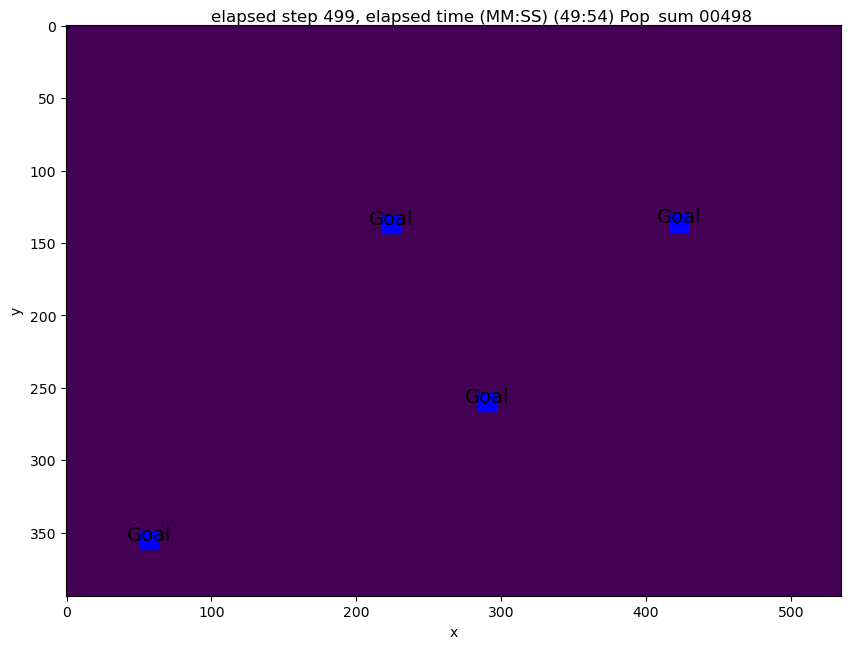

In [71]:
# 計算結果のアニメーションを作成する
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)

# ゴールをプロット
for i in range(len(model.goal_x)):
    plt.text(model.goal_x[i], model.goal_y[i], 'Goal', size = 14, ha = 'center')
plt.scatter(model.goal_x, model.goal_y, color = 'blue', s = 150, marker = "s")

# imshowを使って壁配列を描画する．
plt.imshow(wall)

ims = []
step = 1

# 0 Stepめのエージェントの座標を取得する
agent_loc = model.datacollector.get_agent_vars_dataframe().xs(0, level = 'Step')['Pos'].map(lambda x: (0, 0) if x is None else x)
x0, y0 = [a for a, b in agent_loc], [b for a, b in agent_loc]

# 指定ステップまでアニメーションを作成する
for i in tqdm(range(1, runstep)):

  agent_loc = model.datacollector.get_agent_vars_dataframe().xs(i, level = 'Step')['Pos'].map(lambda x: (0, 0) if x is None else x)
  x, y = [a for a, b in agent_loc], [b for a, b in agent_loc]
  dx = (np.array(x) - np.array(x0)) / step
  dy = (np.array(y) - np.array(y0)) / step
  #データコレクターからプロパティstrategyのリストを取得
  behavior = model.datacollector.get_agent_vars_dataframe().xs(i, level='Step')['Behavior'].map(lambda x: (0, 0) if x is None else x)
  evac_no = model.datacollector.get_agent_vars_dataframe().xs(i, level='Step')['Evac_no'].map(lambda x: (0, 0) if x is None else x)
  start_move = model.datacollector.get_agent_vars_dataframe().xs(i, level='Step')['start_move'].map(lambda x: (0, 0) if x is None else x)

  for u in range(step):
    # cパラメータにstrategyを指定して避難エージェントの色を変える
    # im = ax.scatter(x0 + (dx * u), y0 + (dy * u), s = 20, c = evac_no, cmap = cm.seismic, marker = "*")
    im = ax.scatter(x0 + (dx * u), y0 + (dy * u), s = 20, c = start_move, cmap = cm.seismic, marker = "*")
    # グラフのタイトル作成
    pop_sum = int(model.datacollector.get_model_vars_dataframe().xs(i)['pop_sum'])
    im_title = ax.text(100, -3, f"elapsed step {i:03d}, elapsed time (MM:SS) ({int((i*6)/60):02d}:{(i*6)%60:02d}) Pop_sum {pop_sum:05d}", size = 'large')
    # グラフをリストに加える
    ims.append([im, im_title])
  x0 = x
  y0 = y

#ax.set_title('evacuation')
ax.set_xlabel('x')
ax.set_ylabel('y')

# ArtistAnimationにfigオブジェクトとimsを代入してアニメーションを作成
anim = animation.ArtistAnimation(fig, ims, interval = 50, blit = True)

# Google Colaboratoryの場合必要
rc('animation', html='jshtml')
#plt.close()
#anim

anim.save(base_dir + outfilename + '.mp4')

# ゴール過程のグラフ化

In [ ]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)

goal = model.datacollector.get_model_vars_dataframe()

ax.plot(goal)
plt.show